<a href="https://colab.research.google.com/github/Yoshikawawawa/GoogleColab/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# インポート

In [ ]:
! pip install transformers datasets
! pip install fugashi ipadic

#クローン化　
!git clone https://github.com/ids-cv/wrime.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'wrime' already exists and is not an empty directory.


# データ確認・整理

In [ ]:
import pandas as pd
df_wrime = pd.read_table("/content/wrime/wrime-ver1.tsv")
df_wrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Sentence                   43200 non-null  object
 1   UserID                     43200 non-null  int64 
 2   Datetime                   43200 non-null  object
 3   Train/Dev/Test             43200 non-null  object
 4   Writer_Joy                 43200 non-null  int64 
 5   Writer_Sadness             43200 non-null  int64 
 6   Writer_Anticipation        43200 non-null  int64 
 7   Writer_Surprise            43200 non-null  int64 
 8   Writer_Anger               43200 non-null  int64 
 9   Writer_Fear                43200 non-null  int64 
 10  Writer_Disgust             43200 non-null  int64 
 11  Writer_Trust               43200 non-null  int64 
 12  Reader1_Joy                43200 non-null  int64 
 13  Reader1_Sadness            43200 non-null  int64 
 14  Reader

In [ ]:
#客観感情を配列
emotion_names = ['Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust']
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)
#0を除く
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]

In [ ]:
df_wrime['readers_emotion_intensities']

0        [0, 0, 0, 0, 0, 2, 0, 0]
1        [0, 0, 0, 0, 1, 0, 2, 0]
2        [0, 0, 0, 0, 0, 0, 1, 0]
3        [0, 0, 1, 0, 0, 1, 0, 0]
4        [0, 0, 0, 0, 1, 0, 1, 0]
                   ...           
43195    [0, 0, 0, 0, 1, 0, 1, 0]
43196    [0, 2, 0, 0, 2, 0, 0, 0]
43197    [0, 0, 0, 0, 2, 0, 0, 0]
43198    [0, 2, 0, 0, 0, 0, 0, 0]
43199    [0, 0, 0, 0, 2, 0, 0, 1]
Name: readers_emotion_intensities, Length: 43200, dtype: object

# 訓練・テストに分割

In [ ]:
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train)) 
print('test :', len(df_test))

train : 17104
test : 1133


# 訓練済みモデル・データ整形

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
#東北大学の乾研究室
# 使用するモデルを指定して、トークナイザとモデルを読み込む
MODEL = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=8)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

In [ ]:
from datasets import Dataset
import numpy as np
# 1. Transformers用のデータセット形式に変換
# pandas.DataFrame -> datasets.Dataset
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])
# 2. Tokenizerを適用（モデル入力のための前処理）
def tokenize_function(batch):
    """Tokenizerを適用 （感情強度の正規化も同時に実施する）."""
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length')
    tokenized_batch['labels'] = [x / np.sum(x) for x in batch['readers_emotion_intensities']]  # 総和=1に正規化
    return tokenized_batch

train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

# 訓練開始

In [ ]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric
from transformers import AutoTokenizer

# 評価指標を定義
# https://huggingface.co/docs/transformers/training
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    label_ids = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=label_ids)

# 訓練時の設定
# https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=8,
    num_train_epochs=1.0,
    evaluation_strategy="steps", eval_steps=200)  # 200ステップ毎にテストデータで評価する

# Trainerを生成
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=test_tokenized_dataset,
    compute_metrics=compute_metrics,
)

# 訓練を実行
trainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  import sys
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, Sentence, readers_emotion_intensities. If __index_level_0__, Sentence, readers_emotion_intensities are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 17104
  Nu

Step,Training Loss,Validation Loss,Accuracy
200,No log,0.266146,0.578994
400,No log,0.249556,0.623124
600,0.298300,0.235473,0.673433
800,0.298300,0.222284,0.703442
1000,0.262800,0.217885,0.722860
1200,0.262800,0.216172,0.714916
1400,0.262800,0.210556,0.729038
1600,0.248500,0.209391,0.709620
1800,0.248500,0.206222,0.728155
2000,0.239200,0.203180,0.729921


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, Sentence, readers_emotion_intensities. If __index_level_0__, Sentence, readers_emotion_intensities are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1133
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, Sentence, readers_emotion_intensities. If __index_level_0__, Sentence, readers_emotion_intensities are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1133
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights save

TrainOutput(global_step=2138, training_loss=0.260724951777088, metrics={'train_runtime': 2034.9144, 'train_samples_per_second': 8.405, 'train_steps_per_second': 1.051, 'total_flos': 4500493926531072.0, 'train_loss': 0.260724951777088, 'epoch': 1.0})

In [ ]:
#学習したモデルの保存
model.save_pretrained("/content/drive/MyDrive/BERT/wrime.h5")

#モデルのロード
saved_model = model.from_pretrained("/content/drive/MyDrive/BERT/wrime.h5")

Configuration saved in /content/drive/MyDrive/BERT/wrime.h5/config.json
Model weights saved in /content/drive/MyDrive/BERT/wrime.h5/pytorch_model.bin


# 文章から推論

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20837 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25991 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12417 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12435 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12393 missing from current font.
  font.set_

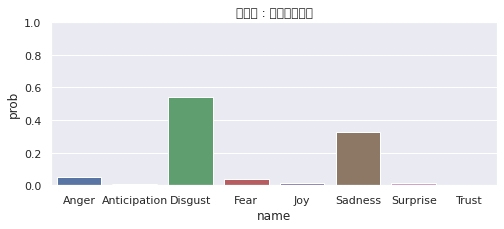

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# ソフトマックス関数
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion(text, show_fig=True):
    # 推論モードを有効化
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names, prob)}

    # 棒グラフを描画
    if show_fig:
        sns.set()
        plt.figure(figsize=(8, 3))
        plt.ylim(0, 1.0)
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text)
    else:
        print(out_dict)
#テキスト入力
analyze_emotion('めんどくさい')